# Import the dependencies

In [1]:
import re
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from matplotlib import pyplot as plt

In [7]:
maxlen = 1_000
batch_size = 32
epochs = 20
num_neurons = 64
onehot_dims = 4

# Load & Prepare the data

In [3]:
enc_dict = {"(": [1.0, .0, .0, .0],
            ")": [.0, 1.0, .0, .0],
            "x": [.0, .0, 1.0, .0],
            "@x.": [.0, .0, .0, 1.0]}
tokens_pattern = r"(\(|\)|@x\.|x)"


def tokenize_data(simplified_term):
    return re.findall(tokens_pattern, simplified_term)


def tokenize_and_vectorize(x_data):
    vectorized_data_ = []
    for sample_ in x_data:
        tokens_ = tokenize_data(sample_)
        sample_vecs_ = []
        for token_ in tokens_:
            try:
                sample_vecs_.append(enc_dict[token_])
            except KeyError:
                pass
        vectorized_data_.append(sample_vecs_)
    return vectorized_data_


def pad_trunc(data_, maxlen_):
    new_data_ = []
    zero_vector_ = [0.0 for _ in range(len(data_[0][0]))]
    for sample_ in data_:
        if len(sample_) > maxlen_:
            temp_ = sample_[:maxlen_]
        elif len(sample_) < maxlen_:
            temp_ = sample_
            additional_elems_ = maxlen_ - len(sample_)
            for _ in range(additional_elems_):
                temp_.append(zero_vector_)
        else:
            temp_ = sample_
        new_data_.append(temp_)
    return new_data_

In [4]:
all_data = pd.read_csv("./data_simplified/collected_sLI_tLO.csv", delimiter='\t')

all_data = pd.concat([all_data, pd.read_csv("./data_simplified/collected_sLI_tRI.csv", delimiter='\t')],
                     ignore_index=True).reset_index(drop=True)
all_data = pd.concat([all_data, pd.read_csv("./data_simplified/collected_sLO_tLO.csv", delimiter='\t')],
                     ignore_index=True).reset_index(drop=True)
all_data = pd.concat([all_data, pd.read_csv("./data_simplified/collected_sLO_tRI.csv", delimiter='\t')],
                     ignore_index=True).reset_index(drop=True)

# filter out count redexes for 0 - 19 & too long tokens sequences
print(f"Count samples before filtering: {len(all_data)}")
all_data = all_data[[redexes < 20 for redexes in all_data["redexes"]]].reset_index(drop=True)
print(f"Count samples after filtering redexes: {len(all_data)}")
all_data = all_data[[len(tokenize_data(simplified_term)) <= 1_000 for simplified_term in all_data['simplified_term']]]
print(f"Count samples after filtering tokens sequences: {len(all_data)}\n")

# shuffle the dataset
all_data = shuffle(all_data, random_state=33).reset_index(drop=True)

# make test/train split
x_train, x_test, y_train, y_test = train_test_split(all_data["simplified_term"].tolist(), all_data["redexes"].tolist(),
                                                    test_size=0.2, random_state=42)

print(f"Count training samples: {len(y_train)}")
print(f"Count testing samples: {len(y_test)}")

Count samples before filtering: 9566
Count samples after filtering redexes: 8911
Count samples after filtering tokens sequences: 8908

Count training samples: 7126
Count testing samples: 1782


In [5]:
# one-hot encode y-data
encoder = LabelBinarizer()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

In [6]:
x_train = pad_trunc(tokenize_and_vectorize(x_train), maxlen)
x_test = pad_trunc(tokenize_and_vectorize(x_test), maxlen)

x_train = np.array(x_train)
x_test = np.array(x_test)

# Define the model

In [8]:
model = Sequential()
model.add(LSTM(units=num_neurons, return_sequences=True,
               input_shape=(maxlen, onehot_dims)))
model.add(Dropout(rate=.2))
model.add(Flatten())
model.add(Dense(20, activation='sigmoid'))

In [9]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1000, 64)          17664     
                                                                 
 dropout (Dropout)           (None, 1000, 64)          0         
                                                                 
 flatten (Flatten)           (None, 64000)             0         
                                                                 
 dense (Dense)               (None, 20)                1280020   
                                                                 
Total params: 1297684 (4.95 MB)
Trainable params: 1297684 (4.95 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                    )

Epoch 1/20
223/223 [==============================] - 98s 427ms/step - loss: 0.1617 - accuracy: 0.2365 - val_loss: 0.1399 - val_accuracy: 0.2654
Epoch 2/20
223/223 [==============================] - 93s 416ms/step - loss: 0.1375 - accuracy: 0.3013 - val_loss: 0.1365 - val_accuracy: 0.3008
Epoch 3/20
223/223 [==============================] - 95s 425ms/step - loss: 0.1299 - accuracy: 0.3518 - val_loss: 0.1302 - val_accuracy: 0.3519
Epoch 4/20
223/223 [==============================] - 92s 414ms/step - loss: 0.1189 - accuracy: 0.4211 - val_loss: 0.1191 - val_accuracy: 0.4282
Epoch 5/20
223/223 [==============================] - 96s 431ms/step - loss: 0.1055 - accuracy: 0.4980 - val_loss: 0.1168 - val_accuracy: 0.4658
Epoch 6/20
223/223 [==============================] - 93s 417ms/step - loss: 0.0899 - accuracy: 0.5981 - val_loss: 0.1026 - val_accuracy: 0.5174
Epoch 7/20
223/223 [==============================] - 93s 417ms/step - loss: 0.0728 - accuracy: 0.6998 - val_loss: 0.0848 - val_ac

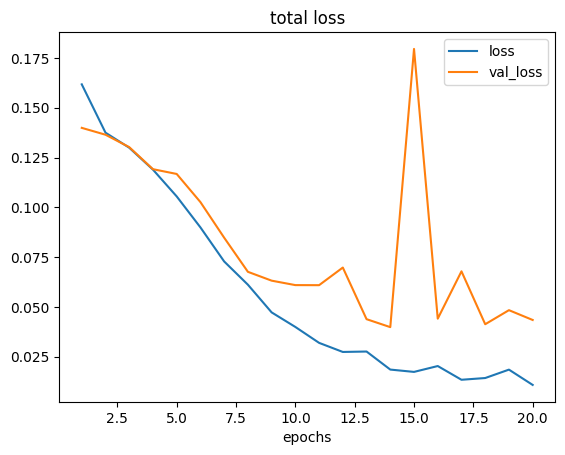

In [12]:
plt.plot(range(1, epochs + 1), history.history['loss'], label="loss")
plt.plot(range(1, epochs + 1), history.history['val_loss'], label="val_loss")
plt.xlabel("epochs")
plt.title("total loss")

plt.legend()
plt.show()

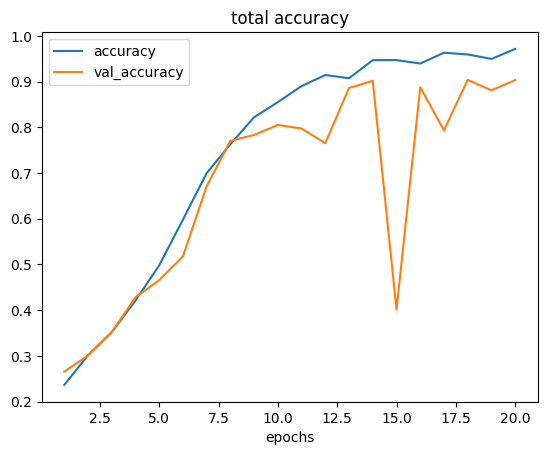

In [13]:
plt.plot(range(1, epochs + 1), history.history['accuracy'], label="accuracy")
plt.plot(range(1, epochs + 1), history.history['val_accuracy'], label="val_accuracy")
plt.xlabel("epochs")
plt.title("total accuracy")

plt.legend()
plt.show()

In [14]:
y_test_pred = model.predict(x_test)

56/56 [==============================] - 6s 92ms/step


In [20]:
def draw_pred_lines(y_pred, y_real):
    drawing_df = pd.DataFrame({"Pred": y_pred, "Real": y_real})
    drawing_df = drawing_df.sort_values("Real").reset_index(drop=True)

    for key_, val_ in drawing_df.items():
        plt.plot(range(len(val_)), val_, label=key_)

    plt.xlabel("No")
    plt.ylabel("Redexes count")
    plt.title("Pred vs Real Step Time")
    plt.legend()
    plt.show()

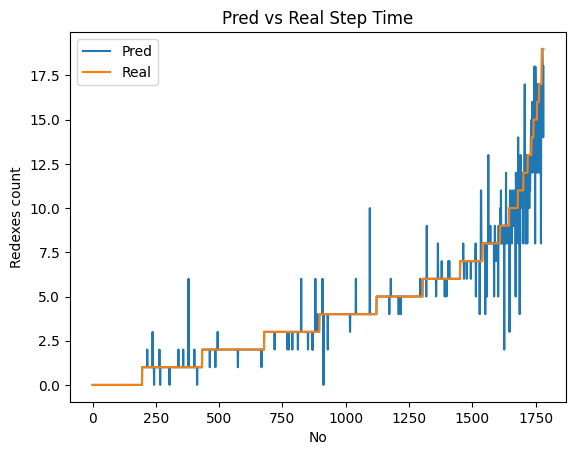

In [21]:
y_test_pred_nums = encoder.inverse_transform(y_test_pred)
y_test_nums = encoder.inverse_transform(y_test)

draw_pred_lines(y_test_pred_nums, y_test_nums)